<a href="https://colab.research.google.com/github/jonDuke/jonDuke.github.io/blob/master/notebooks/Steam_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# The reviews dataset is 115MB, too large to host on github
# Downloading directly from Kaggle requires manually entering your own API key
# I am hosting the files on my drive instead so this can be run on any machine
!pip install PyDrive

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# It will create a link in the output dialogue to log into your google account,
# Log in there and get your authentication link
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# reviews csv file
# original source: https://www.kaggle.com/luthfim/steam-reviews-dataset
downloaded = drive.CreateFile({'id': '1dTOs0U8BUOKXAD-fd6dm9BMM_oqYkhYS'})
downloaded.GetContentFile('steam-reviews.csv')

# users csv file
# original source: https://www.kaggle.com/tamber/steam-video-games
downloaded = drive.CreateFile({'id': '1SRtWFQxrX_imnHfBEMrQJsWtSKt_5z6a'})
downloaded.GetContentFile('steam-users.csv')

In [0]:
# Open datasets with Pandas
import pandas as pd

reviews_df = pd.read_csv("steam-reviews.csv")
users_df = pd.read_csv("steam-users.csv", names=['user_id', 'title', 'behavior', 'value', '0'])

In [5]:
print(reviews_df.shape)
reviews_df.head()

(434891, 8)


,date_posted,funny,helpful,hour_played,is_early_access_review,recommendation,review,title
0,2019-02-10,2,4,578,False,Recommended,&gt Played as German Reich&gt Declare war on B...,Expansion - Hearts of Iron IV: Man the Guns
1,2019-02-10,0,0,184,False,Recommended,yes.,Expansion - Hearts of Iron IV: Man the Guns
2,2019-02-07,0,0,892,False,Recommended,Very good game although a bit overpriced in my...,Expansion - Hearts of Iron IV: Man the Guns
3,2018-06-14,126,1086,676,False,Recommended,Out of all the reviews I wrote This one is pro...,Dead by Daylight
4,2017-06-20,85,2139,612,False,Recommended,Disclaimer I survivor main. I play games for f...,Dead by Daylight


In [6]:
print(users_df.shape)
users_df.head()

(200000, 5)


,user_id,title,behavior,value,0
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0,0
1,151603712,The Elder Scrolls V Skyrim,play,273.0,0
2,151603712,Fallout 4,purchase,1.0,0
3,151603712,Fallout 4,play,87.0,0
4,151603712,Spore,purchase,1.0,0


## Exploratory analysis and data cleaning

### Reviews data

In [7]:
# Starting with the reviews data

# So, 1516 of the reviews don't have review text.  That is valid, users do not 
# have to type any review, only if they recommend it or not.
reviews_df.isnull().sum()

date_posted                  0
funny                        0
helpful                      0
hour_played                  0
is_early_access_review       0
recommendation               0
review                    1516
title                        0
dtype: int64

In [8]:
# Starting with reviews
reviews_df.describe()

,funny,helpful,hour_played
count,4.348910e+05,434891.000000,434891.000000
mean,5.333024e+05,1.004114,364.130773
std,4.785640e+07,59.462935,545.961198
min,0.000000e+00,0.000000,0.000000
25%,0.000000e+00,0.000000,62.000000
50%,0.000000e+00,0.000000,190.000000
75%,0.000000e+00,0.000000,450.000000
max,4.294967e+09,28171.000000,31962.000000


Ok, there's some outliers.  Some review(s) have 4,294,967,000 funny reactions?  What is this review and why has half of everyone on earth said it's funny?

In [9]:
reviews_df[reviews_df['funny'] > 10000].head()

,date_posted,funny,helpful,hour_played,is_early_access_review,recommendation,review,title
46494,2017-05-09,4294967295,1,95,False,Recommended,547tyt,Rocket League®
50161,2016-11-25,4294967295,1,821,False,Recommended,Rocket League. This game can be a fun and redi...,Rocket League®
51447,2017-02-20,4294967288,1,243,False,Recommended,p.u.r.e c.a.n.c.e.r,Rocket League®
51513,2017-08-30,4294967295,1,693,False,Recommended,Very addictive.,Rocket League®
52445,2017-04-10,4294967295,1,1387,False,Recommended,Best game in the history of the universe.Excep...,Rocket League®


Ok, so there are several.  Jokes aside, the maximum value of a 4 byte unsigned int happens to be 4294967295, so safe bet that these are incorrect values (storing negative numbers as unsigned ints will do that).  Let's replace them with the median funny score of 0.

In [0]:
def fix_funny_reviews(count):
  # Could put a higher value here, but this is actually enough
  if(count > 10000):
    return 0
  else:
    return count

reviews_df['funny'] = reviews_df['funny'].apply(fix_funny_reviews)

In [11]:
# New max score is 7472, much more reasonable
reviews_df['funny'].describe()

count    434891.000000
mean          0.374781
std          21.015720
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        7472.000000
Name: funny, dtype: float64

In [12]:
print("Number of reviews with 0 funny votes:", len(reviews_df[reviews_df['funny'] == 0]))
for i in range(0, 1100, 100):
  print("Number of reviews with more than", i, "funny votes:", len(reviews_df[reviews_df['funny'] > i]))

Number of reviews with 0 funny votes: 399710
Number of reviews with more than 0 funny votes: 35181
Number of reviews with more than 100 funny votes: 176
Number of reviews with more than 200 funny votes: 100
Number of reviews with more than 300 funny votes: 60
Number of reviews with more than 400 funny votes: 43
Number of reviews with more than 500 funny votes: 35
Number of reviews with more than 600 funny votes: 28
Number of reviews with more than 700 funny votes: 22
Number of reviews with more than 800 funny votes: 18
Number of reviews with more than 900 funny votes: 17
Number of reviews with more than 1000 funny votes: 15


In [13]:
print("Number of reviews with 0 helpful votes:", len(reviews_df[reviews_df['helpful'] == 0]))
for i in range(0, 1100, 100):
  print("Number of reviews with more than", i, "helpful votes:", len(reviews_df[reviews_df['helpful'] > i]))

Number of reviews with 0 helpful votes: 399656
Number of reviews with more than 0 helpful votes: 35235
Number of reviews with more than 100 helpful votes: 472
Number of reviews with more than 200 helpful votes: 311
Number of reviews with more than 300 helpful votes: 228
Number of reviews with more than 400 helpful votes: 187
Number of reviews with more than 500 helpful votes: 155
Number of reviews with more than 600 helpful votes: 121
Number of reviews with more than 700 helpful votes: 107
Number of reviews with more than 800 helpful votes: 93
Number of reviews with more than 900 helpful votes: 84
Number of reviews with more than 1000 helpful votes: 76


So the vast majority of funny and useful votes are low, but we can probably still use it somewhere.

Another outlier was hours played.  There are 8760 hours in a year, how many of these reviews claim to have played more than that?

In [14]:
print("Number of reviews with 0 hours played:", len(reviews_df[reviews_df['hour_played'] == 0]))
for i in range(0,10000,1000):
  print("Number of reviews with more than", i, "hours played:", 
        len(reviews_df[reviews_df['hour_played'] >= i]))

Number of reviews with 0 hours played: 6258
Number of reviews with more than 0 hours played: 434891
Number of reviews with more than 1000 hours played: 35640
Number of reviews with more than 2000 hours played: 8178
Number of reviews with more than 3000 hours played: 2693
Number of reviews with more than 4000 hours played: 1121
Number of reviews with more than 5000 hours played: 494
Number of reviews with more than 6000 hours played: 264
Number of reviews with more than 7000 hours played: 146
Number of reviews with more than 8000 hours played: 93
Number of reviews with more than 9000 hours played: 63


So this is harder to cut off.  While some of these numbers seem extreme, they are still believable (in the context that Steam isn't 100% accurate at tracking playtime).  For example, some users may have just left the game open on their computer, even if they were not playing.  And while I personally only have one game that is over 1000 hours (that's still a lot!), I know that on the extreme end some people really do put thousands of hours into games.

I am making the decision to leave these values as-is.  This will also make any observations more easily applicable to uncleaned Steam data.

That should be enough for the numerical data, now for the categorical.

In [15]:
# An easy, simple option is converting the date string to an actual datetime object
reviews_df['date_posted'] = pd.to_datetime(reviews_df['date_posted'])
reviews_df['date_posted'].describe()

count                  434891
unique                   1953
top       2017-06-15 00:00:00
freq                     7359
first     2010-12-20 00:00:00
last      2019-02-16 00:00:00
Name: date_posted, dtype: object

In [16]:
# the early access boolean is fine
reviews_df['is_early_access_review'].value_counts()

False    307900
True     126991
Name: is_early_access_review, dtype: int64

In [17]:
# but the recommendation string could be a boolean too
reviews_df['recommendation'].value_counts()

Recommended        303593
Not Recommended    131298
Name: recommendation, dtype: int64

In [18]:
reviews_df['recommendation'] = reviews_df['recommendation'] == 'Recommended'
reviews_df['recommendation'].value_counts()

True     303593
False    131298
Name: recommendation, dtype: int64

In [19]:
# Review text is interesting to me as a person, but meaningless to most programs
# Perhaps later I could try sentiment analysis on it, but for this post I will
# drop it.  I will keep the review length as a new column though.

# check memory usage for comparison in next cell
memory_before = reviews_df.memory_usage(deep=True)

# get a new column of review lengths
reviews_df['review_length'] = pd.Series(len(str(review)) 
                                            for review in reviews_df['review'])

# drop the review text
reviews_df = reviews_df.drop('review', axis=1)

reviews_df.head()

,date_posted,funny,helpful,hour_played,is_early_access_review,recommendation,title,review_length
0,2019-02-10,2,4,578,False,True,Expansion - Hearts of Iron IV: Man the Guns,195
1,2019-02-10,0,0,184,False,True,Expansion - Hearts of Iron IV: Man the Guns,4
2,2019-02-07,0,0,892,False,True,Expansion - Hearts of Iron IV: Man the Guns,171
3,2018-06-14,126,1086,676,False,True,Dead by Daylight,2094
4,2017-06-20,85,2139,612,False,True,Dead by Daylight,1397


In [20]:
# This also has the benefit of drastically reducing its memory usage
# 120588277 bytes -> 3479128 bytes  or  120.5MB -> 3.4MB (for just that column)
print("Before:\n",memory_before)
print("\nAfter:\n",reviews_df.memory_usage(deep=True))

Before:
 Index                           128
date_posted                 3479128
funny                       3479128
helpful                     3479128
hour_played                 3479128
is_early_access_review       434891
recommendation               434891
review                    120588277
title                      34654740
dtype: int64

After:
 Index                          128
date_posted                3479128
funny                      3479128
helpful                    3479128
hour_played                3479128
is_early_access_review      434891
recommendation              434891
title                     34654740
review_length              3479128
dtype: int64


In [21]:
# what do these new review length values look like?
reviews_df['review_length'].describe()

count    434891.000000
mean        217.409873
std         472.760199
min           1.000000
25%          25.000000
50%          71.000000
75%         210.000000
max       31949.000000
Name: review_length, dtype: float64

In [22]:
# Lastly, a quick look at titles
# I'll save cleaning this until I see the other dataframe

print("Number of games reviewed:", len(reviews_df['title'].value_counts()))
print("Number of reviews for each game:")
reviews_df['title'].value_counts()

Number of games reviewed: 48
Number of reviews for each game:


PLAYERUNKNOWN'S BATTLEGROUNDS                    145685
Grand Theft Auto V                                99956
Rust                                              71088
Rocket League®                                    67907
Dead by Daylight                                  22221
MONSTER HUNTER: WORLD                             18412
ASTRONEER                                          2661
The Elder Scrolls V: Skyrim Special Edition        1473
RESIDENT EVIL 2 / BIOHAZARD RE:2                   1385
Sid Meier’s Civilization® VI                        522
Euro Truck Simulator 2                              501
Slay the Spire                                      260
Terraria                                            260
Subnautica                                          247
Left 4 Dead 2                                       221
Insurgency: Sandstorm                               220
RimWorld                                            204
Stardew Valley                                  

Some of the review counts for these games are pretty low, I might want to drop the low-count ones when doing statistical analysis, like the 10's and 3's.



### Users data

In [23]:
# Now for the users data
users_df.head()

,user_id,title,behavior,value,0
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0,0
1,151603712,The Elder Scrolls V Skyrim,play,273.0,0
2,151603712,Fallout 4,purchase,1.0,0
3,151603712,Fallout 4,play,87.0,0
4,151603712,Spore,purchase,1.0,0


From the description on the source Kaggle page, I already know that if behavior is 'purchase', then value is 1.  And if behavior is 'play', then value is the number of hours played.  Not all users who purchase a game play it, so some game/user pairs only have a purchase row.  

But there is no case of a user playing a game but not purchasing it.

In [0]:
# we don't need that 0 column
users_df = users_df.drop('0', axis=1)

In [25]:
# no missing data here
users_df.isnull().sum()

user_id     0
title       0
behavior    0
value       0
dtype: int64

In [26]:
# To combine the behavior data, I'll seperate by purchase and play then merge 
# back together
purchase_df = users_df[users_df['behavior'] == 'purchase']

# Every row in this dataframe indicates that a user owns a game, the behavior 
# column is no longer needed
purchase_df = purchase_df.drop(['behavior', 'value'], axis=1)
purchase_df.head()

,user_id,title
0,151603712,The Elder Scrolls V Skyrim
2,151603712,Fallout 4
4,151603712,Spore
6,151603712,Fallout New Vegas
8,151603712,Left 4 Dead 2


In [27]:
play_df = users_df[users_df['behavior'] == 'play']

# We don't need behavior anymore, but value actually means something here
play_df = play_df.drop('behavior', axis=1)
play_df = play_df.rename({'value': 'hours_played'}, axis=1)
play_df.head()

,user_id,title,hours_played
1,151603712,The Elder Scrolls V Skyrim,273.0
3,151603712,Fallout 4,87.0
5,151603712,Spore,14.9
7,151603712,Fallout New Vegas,12.1
9,151603712,Left 4 Dead 2,8.9


In [0]:
# Left merge to take all rows in purchase_df, find rows where both user_id and 
# title match, then add the hours_played value column from play_df to them
merged_users = pd.merge(purchase_df, play_df, how='left', 
                        on=['user_id', 'title'])

In [29]:
# We're close now, but any rows where a user did not play the game now have NaN
merged_users.isnull().sum()

user_id             0
title               0
hours_played    58750
dtype: int64

In [30]:
import numpy as np

# Replace the NaN's with 0's to show those users played 0 hours
merged_users = merged_users.replace(to_replace=np.nan, value=0)
merged_users.isnull().sum()

user_id         0
title           0
hours_played    0
dtype: int64

In [31]:
# much better!
print(merged_users.shape)
merged_users.head()

(129535, 3)


,user_id,title,hours_played
0,151603712,The Elder Scrolls V Skyrim,273.0
1,151603712,Fallout 4,87.0
2,151603712,Spore,14.9
3,151603712,Fallout New Vegas,12.1
4,151603712,Left 4 Dead 2,8.9


In [32]:
# Now we can meaningfully check information
merged_users.hours_played.describe()

count    129535.000000
mean         26.651008
std         170.961280
min           0.000000
25%           0.000000
50%           0.300000
75%           5.700000
max       11754.000000
Name: hours_played, dtype: float64

In [33]:
print("Number of times a user did not play a game they owned:", 
      len(merged_users[merged_users['hours_played'] == 0]))

Number of times a user did not play a game they owned: 58750


In [34]:
# how many users?
print("We have data for", len(merged_users['user_id'].value_counts()), "different users")

We have data for 12393 different users


In [35]:
# How many titles does each user own?
merged_users.groupby(by='user_id').count()['title']

user_id
5250         21
76767        36
86540        82
103360       10
144736        8
             ..
309554670     1
309626088     1
309812026     2
309824202     1
309903146     1
Name: title, Length: 12393, dtype: int64

In [38]:
# How many users own each game?
merged_users.groupby(by='title').count()['user_id']

title
007 Legends                                                     1
0RBITALIS                                                       3
1... 2... 3... KICK IT! (Drop That Beat Like an Ugly Baby)      7
10 Second Ninja                                                 6
10,000,000                                                      1
                                                             ... 
sZone-Online                                                  102
samurai_jazz                                                    1
the static speaks my name                                      13
theHunter                                                     248
theHunter Primal                                                4
Name: user_id, Length: 5155, dtype: int64

# Answering Questions

## Reviews per game questions

In [39]:
# Start a new dataframe where each row is a unique title
reviewed_games = reviews_df.groupby('title').count()

# drop extra columns, it has one for each numerical value in the original set
# keep that as review_count
reviewed_games = reviewed_games[['date_posted']]
reviewed_games.columns = ['review_count']

# get the recommendation_count column
reviewed_games['recommendation_count'] = (reviews_df.groupby('title')
                                                      .sum()['recommendation'])

# calculate the recommendation_ratio
reviewed_games['recommendation_ratio'] = (reviewed_games['recommendation_count'] 
                                          / reviewed_games['review_count'])

# get average hours played per game
reviewed_games['avg_playtime_reviews'] = (reviews_df.groupby('title')
                        .sum()['hour_played'] / reviewed_games['review_count'])

reviewed_games = reviewed_games.reset_index()
print(reviewed_games.shape)
reviewed_games.head()

(48, 5)


,title,review_count,recommendation_count,recommendation_ratio,avg_playtime_reviews
0,ACE COMBAT™ 7: SKIES UNKNOWN,10,10.0,1.000000,23.900000
1,ARK: Survival Evolved,195,33.0,0.169231,878.364103
2,ASTRONEER,2661,2573.0,0.966930,49.744081
3,Battlefleet Gothic: Armada 2,10,8.0,0.800000,59.100000
4,Beat Saber,10,10.0,1.000000,57.300000


In [0]:
# Creating a function to get ranked lists easier
def sort_games(by, ascending=False, min_review_count=None):
  """
  returns the reviewed games sorted by the given column

  by: column to sort by

  ascending: sort by ascending or decending

  min_review_count: minimum number of reviews a game needs to be included,
                    all games are kept by default
  """
  if min_review_count == None:
    return reviewed_games.sort_values(by=by, ascending=ascending)
  else:
    return (reviewed_games[reviewed_games['review_count'] >= min_review_count]
                                      .sort_values(by=by, ascending=ascending))

### Which games had the highest percentage of recommendations?

In [41]:
# Which games had the highest percentage of recommendations?
sort_games(by='recommendation_ratio').head()

,title,review_count,recommendation_count,recommendation_ratio,avg_playtime_reviews
0,ACE COMBAT™ 7: SKIES UNKNOWN,10,10.0,1.0,23.900000
11,Factorio,170,170.0,1.0,375.223529
45,Wallpaper Engine,170,170.0,1.0,76.982353
44,Tom Clancy's Rainbow Six® Siege,10,10.0,1.0,867.900000
41,Tannenberg,10,10.0,1.0,14.800000


In [63]:
sort_games(by='recommendation_ratio', min_review_count=11).head(10)[['title', 'review_count', 'recommendation_ratio', 'avg_playtime_reviews']]

,title,review_count,recommendation_ratio,avg_playtime_reviews
45,Wallpaper Engine,170,1.000000,76.982353
37,Stardew Valley,202,1.000000,131.009901
30,RimWorld,204,1.000000,251.647059
8,Don't Starve Together,165,1.000000,165.933333
9,Euro Truck Simulator 2,501,1.000000,206.554890
11,Factorio,170,1.000000,375.223529
38,Subnautica,247,1.000000,91.149798
42,Terraria,260,0.996154,421.723077
21,Left 4 Dead 2,221,0.995475,320.072398
29,RESIDENT EVIL 2 / BIOHAZARD RE:2,1385,0.994224,28.093141


In [42]:
sort_games(by='recommendation_ratio', min_review_count=11).head()

,title,review_count,recommendation_count,recommendation_ratio,avg_playtime_reviews
45,Wallpaper Engine,170,170.0,1.0,76.982353
37,Stardew Valley,202,202.0,1.0,131.009901
30,RimWorld,204,204.0,1.0,251.647059
8,Don't Starve Together,165,165.0,1.0,165.933333
9,Euro Truck Simulator 2,501,501.0,1.0,206.554890


### Which games had the most hours played on average by reviewers?

In [43]:
# Which games had the most hours played on average by reviewers?
sort_games(by='avg_playtime_reviews').head()

,title,review_count,recommendation_count,recommendation_ratio,avg_playtime_reviews
16,Garry's Mod,202,196.0,0.970297,1283.688119
1,ARK: Survival Evolved,195,33.0,0.169231,878.364103
44,Tom Clancy's Rainbow Six® Siege,10,10.0,1.000000,867.900000
10,Expansion - Hearts of Iron IV: Man the Guns,3,3.0,1.000000,551.333333
20,Kenshi,10,10.0,1.000000,542.000000


In [44]:
# Lowest hours played?
sort_games(by='avg_playtime_reviews', ascending=True).head()

,title,review_count,recommendation_count,recommendation_ratio,avg_playtime_reviews
39,Subnautica: Below Zero,10,10.0,1.000000,8.300000
18,Human: Fall Flat,172,164.0,0.953488,13.877907
23,Moonlighter,10,5.0,0.500000,14.400000
41,Tannenberg,10,10.0,1.000000,14.800000
14,Foundation,10,8.0,0.800000,16.700000


### Is there a relationship between hours played and recommended ratio?

In [0]:
# Import graphing libraries and set some universal style settings
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

# Start with this as a base
plt.style.use('seaborn-whitegrid')

# Customize some defaults myself
# run this to see all rc values: plt.rcParams
plt.rc('font', size=12)
plt.rc('axes', edgecolor='darkgray', titlesize='x-large')
plt.rc('legend', frameon=True, fontsize='medium')

# Color values I want to use
my_blue = '#3477A8'
my_orange = '#E88E40'
my_red = '#992C2C'
my_green = '#447537'

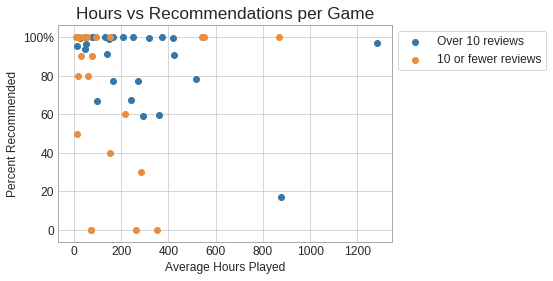

In [64]:
# Answer: not a strong correlation, though there are very few games with both 
#         high average hours and low review scores
df = reviewed_games[reviewed_games['review_count'] > 10]
p1 = plt.scatter(x=df['avg_playtime_reviews'], y=df['recommendation_ratio']*100, 
                 color=my_blue)

df = reviewed_games[reviewed_games['review_count'] <= 10]
p2 = plt.scatter(x=df['avg_playtime_reviews'], y=df['recommendation_ratio']*100, 
                 color=my_orange)

plt.title('Hours vs Recommendations per Game')
plt.xlabel('Average Hours Played')
plt.yticks(ticks=[0,20,40,60,80,100], labels=[0,20,40,60,80,'100%'])
plt.ylabel('Percent Recommended')

plt.legend(handles=[p1, p2], labels=['Over 10 reviews', '10 or fewer reviews'], 
           bbox_to_anchor=(1, 1));

In [47]:
# The correlation is much higher when only including games with more than 10 
# reviews, but still not very strong
correlation = np.corrcoef([reviewed_games['avg_playtime_reviews'], 
                           reviewed_games['recommendation_ratio']])
print("Correlation coefficient with all games:", correlation[0][1])

high_games = reviewed_games[reviewed_games['review_count'] > 10]
correlation = np.corrcoef([high_games['avg_playtime_reviews'], 
                           high_games['recommendation_ratio']])
print("Correlation coefficient with highly reviewed games:", correlation[0][1])

Correlation coefficient with all games: -0.06919160004845161
Correlation coefficient with highly reviewed games: -0.35314266037972164


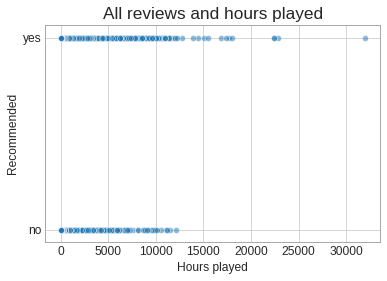

In [48]:
# Graphing this from the original set
sns.scatterplot(x=reviews_df['hour_played'], y=reviews_df['recommendation'], alpha=.5)
plt.title('All reviews and hours played')
plt.xlabel('Hours played')
plt.ylabel('Recommended')
plt.yticks(ticks=[0, 1], labels=['no', 'yes']);

plt.savefig('all-reviews-hrs-played.png')

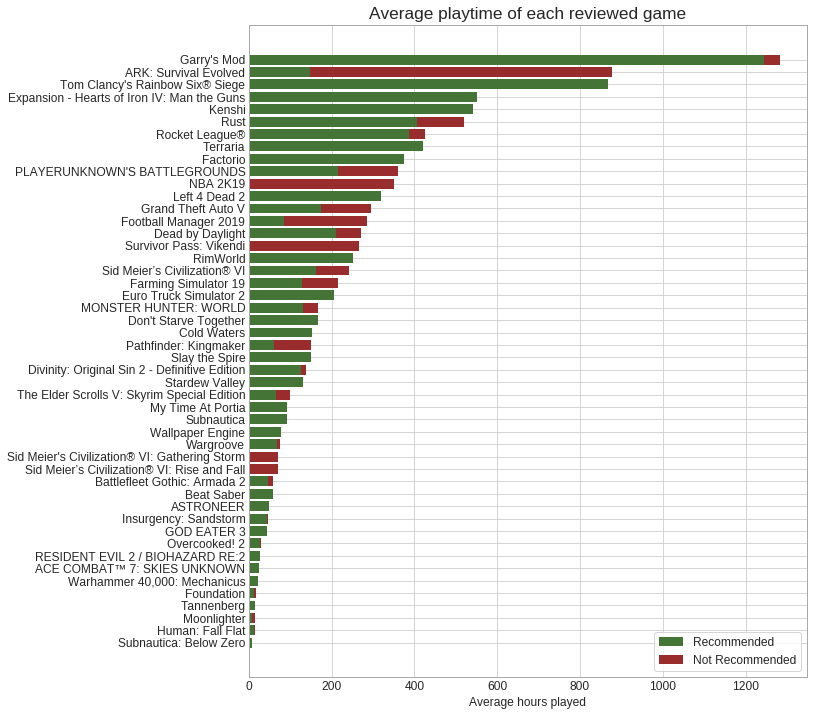

In [49]:
# Graph of each game's hours played, shaded by recommendation
sorted_games = sort_games(by='avg_playtime_reviews', ascending=True)

fig, ax = plt.subplots()
fig.set_size_inches(10,12)

good_review_heights = (sorted_games['avg_playtime_reviews'] * 
                       sorted_games['recommendation_ratio'])
bad_review_heights = sorted_games['avg_playtime_reviews'] - good_review_heights

p1 = plt.barh(y=sorted_games['title'], width=good_review_heights, 
              color=my_green)
p2 = plt.barh(y=sorted_games['title'], width=bad_review_heights, 
              left=good_review_heights, color=my_red)

plt.title('Average playtime of each reviewed game')
plt.xlabel('Average hours played')
plt.legend([p1, p2], ['Recommended', 'Not Recommended'], loc='lower right');

#plt.savefig('avg-playtime-all-games.png')

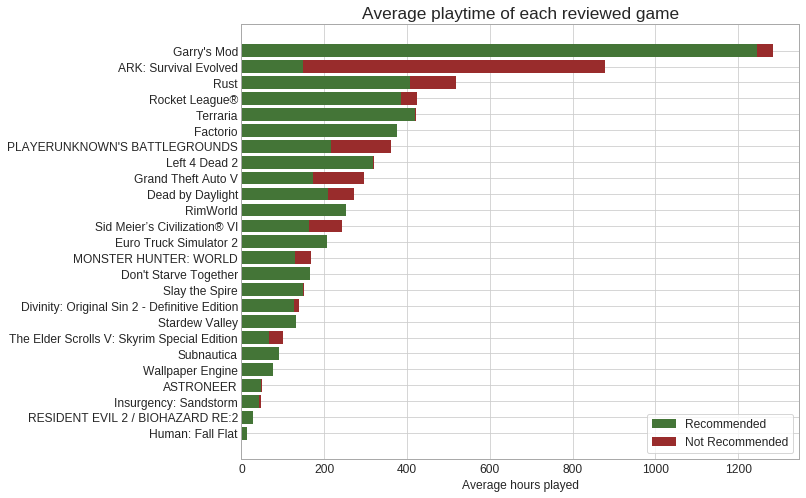

In [50]:
# Same graph, but only including games over 10 reviews
sorted_games = sort_games(by='avg_playtime_reviews', ascending=True, 
                          min_review_count=11)

fig, ax = plt.subplots()
fig.set_size_inches(10,8)

good_review_heights = (sorted_games['avg_playtime_reviews'] * 
                       sorted_games['recommendation_ratio'])
bad_review_heights = sorted_games['avg_playtime_reviews'] - good_review_heights

p1 = plt.barh(y=sorted_games['title'], width=good_review_heights, 
              color=my_green)
p2 = plt.barh(y=sorted_games['title'], width=bad_review_heights, 
              left=good_review_heights, color=my_red)

plt.title('Average playtime of each reviewed game')
plt.xlabel('Average hours played')
plt.legend([p1, p2], ['Recommended', 'Not Recommended'], loc='lower right');

#plt.savefig('avg-playtime-reviewed-games.png')

## Review questions

### How common is it to play many hours yet not recommend a game?

In [51]:
# what is the mean/median hours played?
reviews_df['hour_played'].describe()

count    434891.000000
mean        364.130773
std         545.961198
min           0.000000
25%          62.000000
50%         190.000000
75%         450.000000
max       31962.000000
Name: hour_played, dtype: float64

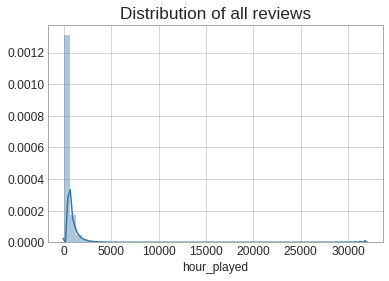

In [52]:
sns.distplot(reviews_df['hour_played'], color=my_blue)
plt.title('Distribution of all reviews');

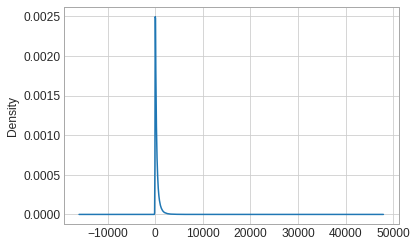

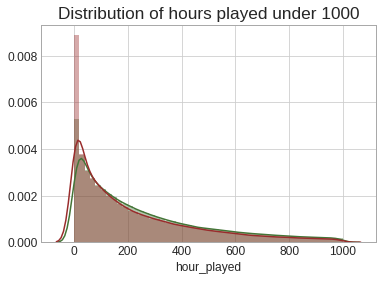

In [66]:
# The vast majority of games is between 0 and 1000 hours
recommended = reviews_df[reviews_df['recommendation']]
not_recommended = reviews_df[~reviews_df['recommendation']]

sns.distplot(recommended[recommended['hour_played'] <= 1000]['hour_played'], 
             color=my_green)
sns.distplot(not_recommended[not_recommended['hour_played'] <= 1000]['hour_played'], 
             color=my_red)
plt.title('Distribution of hours played under 1000');

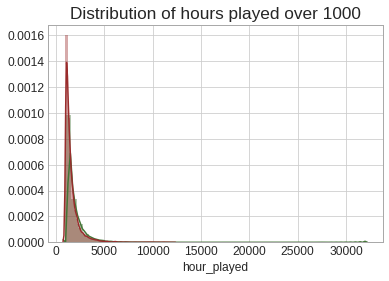

In [67]:
sns.distplot(recommended[recommended['hour_played'] > 1000]['hour_played'], 
             color=my_green)
sns.distplot(not_recommended[not_recommended['hour_played'] > 1000]['hour_played'], 
             color=my_red)
plt.title('Distribution of hours played over 1000');

In [68]:
# If I arbitrarily define "many hours" as...
# median = 190, mean = 364
hours = 190

count = len(reviews_df[reviews_df['hour_played'] >= hours])
ratio = (reviews_df[reviews_df['hour_played'] >= hours]['recommendation'].sum() 
          / count)
print(count, 'reviewers have played over', hours, 
      'hours, and they recommend the game', round(ratio*100,2), '% of the time')

count = len(reviews_df[reviews_df['hour_played'] < hours])
ratio = (reviews_df[reviews_df['hour_played'] < hours]['recommendation'].sum() 
          / count)
print(count, 'reviewers have played under', hours, 
      'hours, and they recommend the game', round(ratio*100,2), '% of the time')

217720 reviewers have played over 190 hours, and they recommend the game 73.23 % of the time
217171 reviewers have played under 190 hours, and they recommend the game 66.38 % of the time


So players who have played more than the median of 190 hours recommend their games about 7% more often.  Is that signifigant?

T test for signifigance:

$H_0:$ The average amount of recommendations is the same between players who play more than the average of 364 hours and those that play less.

$H_1:$ The average amount of recommendations between those groups is different.

Confidence Level: 95%

In [69]:
from scipy.stats import ttest_ind

ttest_ind(reviews_df[reviews_df['hour_played'] >= hours]['recommendation'],
          reviews_df[reviews_df['hour_played'] < hours]['recommendation'])

Ttest_indResult(statistic=49.3455169311061, pvalue=0.0)

Due to a p-value of 0, I reject the null hypothesis that the means are the same and suggest they are different.

Or in plain English: I can confirm that, statistically, players who play their games more than the average of 364 hours recommend the games more often on average than those that play fewer hours.

### How many reviewers did not play the game they reviewed?

In [70]:
print(len(reviews_df[reviews_df['hour_played'] == 0]), 
      'reviewers have 0 hours recorded actually playing the game')

6258 reviewers have 0 hours recorded actually playing the game


### Are reviews longer when recommending a game, or not?

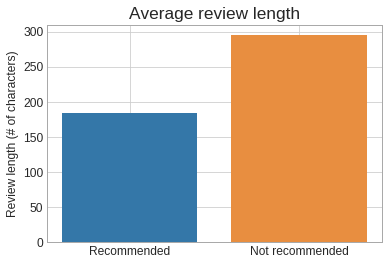

In [71]:
# Average review lengths
plt.bar(x=0, height=recommended['review_length'].mean(), color=my_blue)
plt.bar(x=1, height=not_recommended['review_length'].mean(), color=my_orange)
plt.title('Average review length')
plt.ylabel('Review length (# of characters)')
plt.xticks(ticks=[0, 1], labels=['Recommended', 'Not recommended']);

plt.savefig('avg-review-length-bar.png')

In [110]:
print("Positive reviews had an average length of", 
      recommended['review_length'].mean())
print("Negative reviews had an average length of", 
      not_recommended['review_length'].mean())

Positive reviews had an average length of 183.97512788503028
Negative reviews had an average length of 294.7191579460464


### Are early access reviews recommended more often than not?

In [72]:
# Are early access reviews recommended more often than not?
# Answer: maybe a small difference?  Try a T-test
early_count = reviews_df['is_early_access_review'].sum()
print(early_count, "out of", len(reviews_df), "reviews were in early access")

126991 out of 434891 reviews were in early access


In [73]:
early_recommended = reviews_df[reviews_df['is_early_access_review']]['recommendation'].sum()
print(str(((early_recommended/early_count)*100).round(2))+
      "% of early access reviews were recommended")

late_count = len(reviews_df) - early_count
late_recommended = reviews_df[~reviews_df['is_early_access_review']]['recommendation'].sum()
print(str(((late_recommended/late_count)*100).round(2))+
      "% of non-early access reviews were recommended")

76.45% of early access reviews were recommended
67.07% of non-early access reviews were recommended


Again, this is only a difference of about 9%.  Let's try another t-test to be sure:

$H_0:$ The average amount of recommendations is the same between players who played during early access and those who did not.

$H_1:$ The average amount of recommendations between those groups is different.

Confidence Level: 95%

In [74]:
ttest_ind(reviews_df[reviews_df['is_early_access_review']]['recommendation'],
          reviews_df[~reviews_df['is_early_access_review']]['recommendation'])

Ttest_indResult(statistic=61.48949641301186, pvalue=0.0)

Due to a p-value of 0, I can reject the null hypothesis that the means are the same and instead suggest they are different.

So we can statistically show that overall, games that were in early access while being reviewed are reviewed slightly more favorably.

### Is there a relationship between length of the review and if it was found funny or helpful?

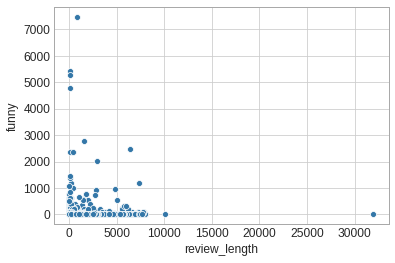

In [75]:
# Is there a relationship between length of the review and if it was found funny or helpful?
# Answer: doesn't look like it
sns.scatterplot(x=reviews_df['review_length'], y=reviews_df['funny'], color=my_blue);

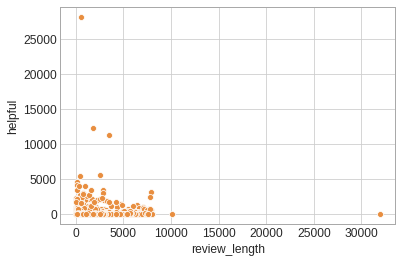

In [76]:
sns.scatterplot(x=reviews_df['review_length'], y=reviews_df['helpful'], color=my_orange);

In [77]:
#excluding outliers
trimmed_reviews = reviews_df[reviews_df['review_length'] < 10000]
print(len(reviews_df) - len(trimmed_reviews), 'reviews removed by review length')

count = len(trimmed_reviews)
trimmed_reviews = trimmed_reviews[trimmed_reviews['helpful'] < 10000]
print(count - len(trimmed_reviews), 'reviews removed by helpful count')

count = len(trimmed_reviews)
trimmed_reviews = trimmed_reviews[trimmed_reviews['funny'] < 4000]
print(count - len(trimmed_reviews), 'reviews removed by funny count')

2 reviews removed by review length
3 reviews removed by helpful count
4 reviews removed by funny count


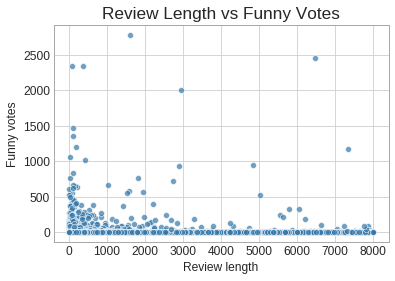

In [78]:
sns.scatterplot(x=trimmed_reviews['review_length'], y=trimmed_reviews['funny'], 
                alpha=.7, color=my_blue)
plt.title('Review Length vs Funny Votes')
plt.xlabel('Review length')
plt.ylabel('Funny votes');

plt.savefig('review-length-funny-scatter.png')

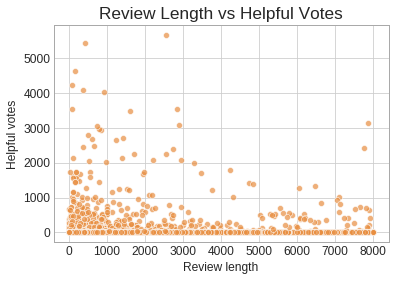

In [79]:
sns.scatterplot(x=trimmed_reviews['review_length'], y=trimmed_reviews['helpful'], 
                alpha=.7, color=my_orange)
plt.title('Review Length vs Helpful Votes')
plt.xlabel('Review length')
plt.ylabel('Helpful votes');

plt.savefig('review-length-helpful-scatter.png')

In [80]:
# Pretty low correlation, even after removing outliers
correlation = np.corrcoef([trimmed_reviews['review_length'], 
                           trimmed_reviews['funny']])
print("Correlation coefficient of length to funny:", correlation[0][1])

correlation = np.corrcoef([trimmed_reviews['review_length'], 
                           trimmed_reviews['helpful']])
print("Correlation coefficient with length to helpful:", correlation[0][1])

Correlation coefficient of length to funny: 0.0336179188683173
Correlation coefficient with length to helpful: 0.0627425086570904


### Is there a relationship between reviews that recommended the game, and were found either funny or helpful?

In [81]:
# Average funny and helpful scores, grouped by recommendation
reviews_df.groupby(by='recommendation').mean()[['funny', 'helpful']]

,funny,helpful
recommendation,,
False,0.304917,0.943289
True,0.404996,1.030419


## Ownership questions

In [82]:
merged_users.head()

,user_id,title,hours_played
0,151603712,The Elder Scrolls V Skyrim,273.0
1,151603712,Fallout 4,87.0
2,151603712,Spore,14.9
3,151603712,Fallout New Vegas,12.1
4,151603712,Left 4 Dead 2,8.9


### How many games on average does each user own?

In [83]:
print('On average, each user in this set owns', 
      round(merged_users['user_id'].value_counts().mean(), 2), 'games')

On average, each user in this set owns 10.45 games


In [114]:
merged_users['user_id'].value_counts().describe()

count    12393.000000
mean        10.452271
std         35.872321
min          1.000000
25%          1.000000
50%          2.000000
75%          6.000000
max       1075.000000
Name: user_id, dtype: float64

### How many of their games does each user play?

In [84]:
# need to reshape data to get that
users = merged_users['user_id'].value_counts().reset_index()
users.columns = ['user_id', 'games_owned']
users.head()

,user_id,games_owned
0,62990992,1075
1,33865373,785
2,30246419,766
3,58345543,667
4,76892907,597


In [85]:
# For each user, sum up the hours played on all games
# This takes about 30 seconds to run!
new_col = []
for user in users['user_id']:
  condition = ((merged_users['user_id'] == user) & 
              (merged_users['hours_played'] == 0))
  new_col.append(len(merged_users[condition]))

users['unplayed_count'] = new_col
users.head()

,user_id,games_owned,unplayed_count
0,62990992,1075,577
1,33865373,785,614
2,30246419,766,631
3,58345543,667,501
4,76892907,597,499


In [86]:
# check a random user to make sure I did that right
print(users.loc[[2600]])
print(merged_users[merged_users['user_id'] == users['user_id'][2600]])

        user_id  games_owned  unplayed_count
2600  181966419            8               2
         user_id                            title  hours_played
58308  181966419                           Dota 2         282.0
58309  181966419       The Elder Scrolls V Skyrim          18.6
58310  181966419                         BioShock           2.4
58311  181966419  Counter-Strike Global Offensive           1.7
58312  181966419                            SMITE           1.6
58313  181966419    Middle-earth Shadow of Mordor           0.7
58314  181966419                       BioShock 2           0.0
58315  181966419                BioShock Infinite           0.0


In [87]:
# actual answer:
avg = 1 - (users['unplayed_count'] / users['games_owned']).mean()
print('On average, each user plays', round(avg * 100, 2), 
      '% of the games they buy')

On average, each user plays 72.68 % of the games they buy


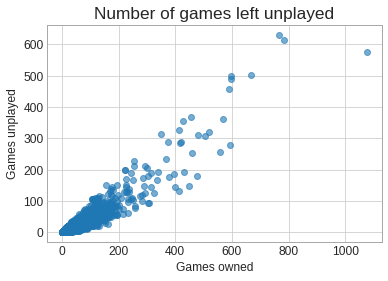

In [127]:
plt.scatter(x=users['games_owned'], y=users['unplayed_count'], alpha=.6)
plt.title('Number of games left unplayed')
plt.xlabel('Games owned')
plt.ylabel('Games unplayed');

plt.savefig('games-unplayed-scatter.png')

Personal note - I'm well below that average thanks to sales and humble bundles

### How many hours, on average, has each user played in total?

In [88]:
# Get that data the same way we got unplayed_count
new_col = []
for user in users['user_id']:
  condition = (merged_users['user_id'] == user)
  new_col.append(merged_users[condition]['hours_played'].sum())

users['hours_played'] = new_col
users.head()

,user_id,games_owned,unplayed_count,hours_played
0,62990992,1075,577,5724.8
1,33865373,785,614,2438.8
2,30246419,766,631,1219.7
3,58345543,667,501,1374.9
4,76892907,597,499,2731.3


In [89]:
# again, check results
print(users.loc[[2600]])
print(merged_users[merged_users['user_id'] == users['user_id'][2600]])

        user_id  games_owned  unplayed_count  hours_played
2600  181966419            8               2         307.0
         user_id                            title  hours_played
58308  181966419                           Dota 2         282.0
58309  181966419       The Elder Scrolls V Skyrim          18.6
58310  181966419                         BioShock           2.4
58311  181966419  Counter-Strike Global Offensive           1.7
58312  181966419                            SMITE           1.6
58313  181966419    Middle-earth Shadow of Mordor           0.7
58314  181966419                       BioShock 2           0.0
58315  181966419                BioShock Infinite           0.0


In [90]:
users['hours_played'].describe()

count    12393.000000
mean       278.563568
std        761.469827
min          0.000000
25%          1.300000
50%         13.500000
75%        156.400000
max      11754.000000
Name: hours_played, dtype: float64

In [91]:
# answer: 
print("The average playtime across all users and all games is", 
      round(users['hours_played'].mean(), 2), "hours")

The average playtime across all users and all games is 278.56 hours


In [92]:
print(len(users[users['hours_played'] == 0]), 
      'users in this data have not played any games, but still own some')

1043 users in this data have not played any games, but still own some


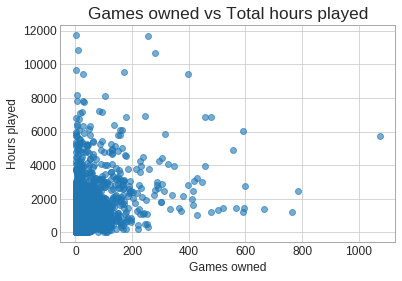

In [132]:
plt.scatter(x=users['games_owned'], y=users['hours_played'], alpha=.6)
plt.title('Games owned vs Total hours played')
plt.xlabel('Games owned')
plt.ylabel('Hours played');

## Per game ownership questions

### What games are more often bought and not played?

In [93]:
# I will need to group the data similarly to how I grouped the reviews per game
owned_games = merged_users.groupby('title').count()

owned_games = owned_games.drop('hours_played', axis=1)
owned_games.columns = ['owned_count']

# Add the sum of hours_played for each title in merged_users
owned_games['total_hours_played'] = (merged_users.groupby(by='title')
                                                        .sum()['hours_played'])

# average hours played
owned_games['avg_playtime_users'] = (owned_games['total_hours_played'] / 
                               owned_games['owned_count'])

owned_games = owned_games.reset_index()
owned_games.head()

,title,owned_count,total_hours_played,avg_playtime_users
0,007 Legends,1,0.7,0.700000
1,0RBITALIS,3,1.2,0.400000
2,1... 2... 3... KICK IT! (Drop That Beat Like a...,7,20.0,2.857143
3,10 Second Ninja,6,5.9,0.983333
4,"10,000,000",1,3.6,3.600000


### What games are more often bought and not played?

In [94]:
# all games never played
owned_games[owned_games['total_hours_played'] == 0]

,title,owned_count,total_hours_played,avg_playtime_users
12,16 Bit Arena,7,0.0,0.0
14,1701 A.D. Gold Edition,1,0.0,0.0
17,1953 - KGB Unleashed,4,0.0,0.0
19,1954 Alcatraz,3,0.0,0.0
20,1Heart,1,0.0,0.0
...,...,...,...,...
5126,eXceed 2nd - Vampire REX,2,0.0,0.0
5127,eXceed 3rd - Jade Penetrate Black Package,2,0.0,0.0
5137,iRacing,1,0.0,0.0
5139,in Space,1,0.0,0.0


In [95]:
# top 10 games played the least, but still played at least some
owned_games[owned_games['total_hours_played'] > 0].sort_values('total_hours_played').head(10)

,title,owned_count,total_hours_played,avg_playtime_users
2017,Guardians of Orion,2,0.1,0.050000
1270,Diamond Dan,1,0.1,0.100000
2203,Hyper Fighters,16,0.1,0.006250
3776,Shan Gui,2,0.1,0.050000
68,A-Train 8,3,0.1,0.033333
224,Alien Shooter Revisited,1,0.1,0.100000
4774,Unity of Command,2,0.1,0.050000
4972,Wildlife Park 2 - Marine World,2,0.1,0.050000
2271,Inside a Star-filled Sky,1,0.1,0.100000
1627,FLOCK!,1,0.1,0.100000


In [96]:
# top 10 games played the least, but still played at least 1 hour
owned_games[owned_games['total_hours_played'] >= 1].sort_values('total_hours_played').head(10)

,title,owned_count,total_hours_played,avg_playtime_users
2981,Obscure 2,1,1.0,1.000000
1088,Damnation City of Death,1,1.0,1.000000
515,Big Brain Wolf,2,1.0,0.500000
3235,Potatoman Seeks the Troof,2,1.0,0.500000
5136,iO,2,1.0,0.500000
497,Bejeweled Deluxe,1,1.0,1.000000
4940,Wasteland Angel,5,1.0,0.200000
798,Castlevania Lords of Shadow Mirror of Fate HD,4,1.0,0.250000
1113,Darkout,3,1.0,0.333333
1295,Distant Star Revenant Fleet,2,1.0,0.500000


### Which games are played the most?

In [141]:
# top 10 games played the most
owned_games.sort_values('total_hours_played', ascending=False).head(10)

,title,owned_count,total_hours_played,avg_playtime_users
1336,Dota 2,4841,981684.6,202.785499
981,Counter-Strike Global Offensive,1412,322771.6,228.591785
4257,Team Fortress 2,2323,173673.3,74.762505
978,Counter-Strike,856,134261.1,156.847079
3825,Sid Meier's Civilization V,596,99821.3,167.485403
984,Counter-Strike Source,978,96075.5,98.236708
4364,The Elder Scrolls V Skyrim,717,70889.3,98.869317
1894,Garry's Mod,731,49725.3,68.023666
737,Call of Duty Modern Warfare 2 - Multiplayer,343,42009.9,122.477843
2475,Left 4 Dead 2,951,33596.7,35.327760


In [98]:
# top 10 most owned games
owned_games.sort_values('owned_count', ascending=False).head(10)

,title,owned_count,total_hours_played,avg_playtime_users
1336,Dota 2,4841,981684.6,202.785499
4257,Team Fortress 2,2323,173673.3,74.762505
4788,Unturned,1563,16096.4,10.298401
981,Counter-Strike Global Offensive,1412,322771.6,228.591785
2074,Half-Life 2 Lost Coast,981,184.4,0.187971
984,Counter-Strike Source,978,96075.5,98.236708
2475,Left 4 Dead 2,951,33596.7,35.327760
978,Counter-Strike,856,134261.1,156.847079
4899,Warframe,847,27074.6,31.965289
2071,Half-Life 2 Deathmatch,823,3712.9,4.511422


In [99]:
# top 10 games with highest average playtime
owned_games.sort_values('avg_playtime_users', ascending=False).head(10)

,title,owned_count,total_hours_played,avg_playtime_users
1458,Eastside Hockey Manager,1,1295.0,1295.000000
1606,FIFA Manager 09,1,411.0,411.000000
3130,Perpetuum,4,1603.9,400.975000
1762,Football Manager 2012,80,30845.8,385.572500
1764,Football Manager 2014,80,30574.8,382.185000
1760,Football Manager 2010,38,13126.7,345.439474
1761,Football Manager 2011,34,11336.8,333.435294
3045,Out of the Park Baseball 16,2,660.8,330.400000
1763,Football Manager 2013,104,32308.6,310.659615
1765,Football Manager 2015,79,24283.1,307.381013


In [136]:
print('The average total hours played among all games is', 
      owned_games.total_hours_played.mean())

The average total hours played among all games is 669.6873520853528


In [138]:
print('The average amount of owners for each game is',
      owned_games['owned_count'].mean())

The average amount of owners for each game is 25.128031037827352


In [139]:
print('The average amount of hours played per user is',
      owned_games['avg_playtime_users'].mean())

The average amount of hours played per user is 6.749563375455631


## Combining datasets questions

In [100]:
# What games are in both datasets?
merged_games = pd.merge(reviewed_games, owned_games, how='inner', on='title')
merged_games

,title,review_count,recommendation_count,recommendation_ratio,avg_playtime_reviews,owned_count,total_hours_played,avg_playtime_users
0,Euro Truck Simulator 2,501,501.0,1.000000,206.554890,187,7226.9,38.646524
1,Garry's Mod,202,196.0,0.970297,1283.688119,731,49725.3,68.023666
2,Grand Theft Auto V,99956,58989.0,0.590150,294.905078,273,22956.7,84.090476
3,Kenshi,10,10.0,1.000000,542.000000,5,266.7,53.340000
4,Left 4 Dead 2,221,220.0,0.995475,320.072398,951,33596.7,35.327760
5,Rust,71088,55785.0,0.784732,519.191073,214,15275.3,71.379907
6,Subnautica,247,247.0,1.000000,91.149798,14,128.9,9.207143
7,Terraria,260,259.0,0.996154,421.723077,496,29951.8,60.386694


In [101]:
# Only 8?  Out of 48 in one and 5155 in the other, let's see if we can find more

# I looked for how to compare string similarity and found Levenshtein Distance
# This measures the number of single-character edits needed to convert one 
# string to another
pip install python-Levenshtein

     |████████████████████████████████| 51kB 1.7MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.0-cp36-cp36m-linux_x86_64.whl size=144674 sha256=3ac0023fafb0e4b01546b09cab03ba2be32e5a5daeb48c13f4278046e0493d11
  Stored in directory: /root/.cache/pip/wheels/de/c2/93/660fd5f7559049268ad2dc6d81c4e39e9e36518766eaf7e342
Successfully built python-Levenshtein


In [102]:
import Levenshtein

lev_matches = []
for t1 in reviewed_games['title']:  # 48 of these
  for t2 in owned_games['title']:   # 5155 of these
    dist = Levenshtein.distance(t1, t2)
    if dist <= 5 and dist > 0:  # if not an exact match, or under threshold
      lev_matches.append({t1: t2})

print('Matches found: ', len(lev_matches))

Matches found:  431


In [0]:
# Some good finds here, but most still don't match.  It matches sequels, and 
# also any two words that are shorter than 5 characters

# I've hidden the output to keep things shorter, but it is interesting to see 
# what got matched.  Uncomment the print line below to see it
# print(np.array(lev_matches))

In [104]:
# For this dataset I went through the list manually, here are the good matches
matches = {'ARK: Survival Evolved': 'ARK Survival Evolved',
           "Don't Starve Together": "Don't Starve Together Beta",
           'Rocket League®': 'Rocket League',
           "Tom Clancy's Rainbow Six® Siege": "Tom Clancy's Rainbow Six Siege"}

# As an additional note, the owned games dataset source did not list a time 
# period the data was taken from.  Seeing this list, and examples such as 
# 'Football Manager 2019' matching with all the Football Manager games from 
# 2009-2016, it is now abundantly clear the two sets are from different times.  
# There are many sequels this method found, but those are not valid matches.

# convert titles in one of the sets
reviewed_games = reviewed_games.replace({'title': matches})

# re-do the merge, now we have 12 games instead of 8
merged_games = pd.merge(reviewed_games, owned_games, how='inner', on='title')
merged_games.round(2)

,title,review_count,recommendation_count,recommendation_ratio,avg_playtime_reviews,owned_count,total_hours_played,avg_playtime_users
0,ARK Survival Evolved,195,33.0,0.17,878.36,163,13593.1,83.39
1,Don't Starve Together Beta,165,165.0,1.00,165.93,256,2031.9,7.94
2,Euro Truck Simulator 2,501,501.0,1.00,206.55,187,7226.9,38.65
3,Garry's Mod,202,196.0,0.97,1283.69,731,49725.3,68.02
4,Grand Theft Auto V,99956,58989.0,0.59,294.91,273,22956.7,84.09
5,Kenshi,10,10.0,1.00,542.00,5,266.7,53.34
6,Left 4 Dead 2,221,220.0,1.00,320.07,951,33596.7,35.33
7,Rocket League,67907,61743.0,0.91,424.55,157,7827.2,49.85
8,Rust,71088,55785.0,0.78,519.19,214,15275.3,71.38
9,Subnautica,247,247.0,1.00,91.15,14,128.9,9.21


### How close are the average playtimes for common games between the two datasets?

In [105]:
# answer: very different!  for truly random samples, these should be more similar
merged_games[['title', 'avg_playtime_reviews', 'avg_playtime_users']].round(2)

,title,avg_playtime_reviews,avg_playtime_users
0,ARK Survival Evolved,878.36,83.39
1,Don't Starve Together Beta,165.93,7.94
2,Euro Truck Simulator 2,206.55,38.65
3,Garry's Mod,1283.69,68.02
4,Grand Theft Auto V,294.91,84.09
5,Kenshi,542.00,53.34
6,Left 4 Dead 2,320.07,35.33
7,Rocket League,424.55,49.85
8,Rust,519.19,71.38
9,Subnautica,91.15,9.21


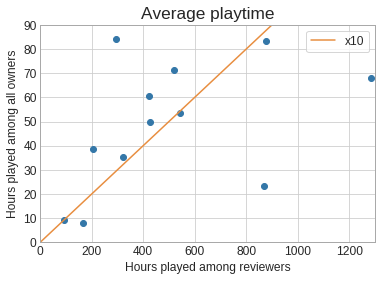

In [159]:
line = plt.plot([0, 1300], [0, 130], color=my_orange)
plt.scatter(x=merged_games['avg_playtime_reviews'], 
            y=merged_games['avg_playtime_users'], color=my_blue)
plt.title('Average playtime')
plt.xlabel('Hours played among reviewers')
plt.ylabel('Hours played among all owners')

plt.legend(handles=line, labels=['x10'])
plt.ylim(bottom=0, top=90)
plt.xlim(left=0, right=1300);

plt.savefig('avg-playtime-scatter')

### How strong is the relationship between number of owners and number of reviews?

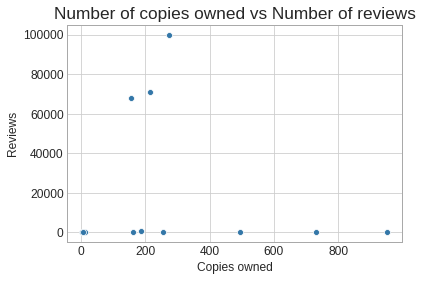

In [106]:
# answer: between these datasets?  not good
sns.scatterplot(x=merged_games['owned_count'], y=merged_games['review_count'],
                color=my_blue)
plt.title('Number of copies owned vs Number of reviews')
plt.xlabel('Copies owned')
plt.ylabel('Reviews');

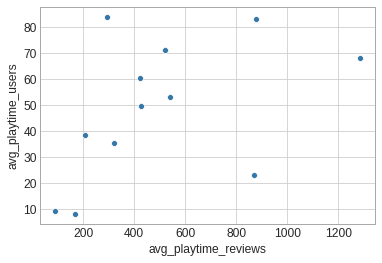

In [107]:
# We also have playtime between both, it's a little closer at least
sns.scatterplot(x=merged_games['avg_playtime_reviews'], 
                y=merged_games['avg_playtime_users'], 
                color=my_blue);

### Relationship between recommended ratio and hours played?

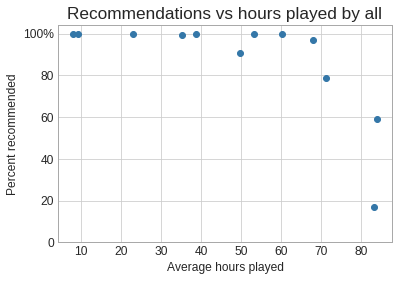

In [163]:
# Relationship between recommended ratio and hours played?
plt.scatter(x=merged_games['avg_playtime_users'], 
                y=merged_games['recommendation_ratio']*100, 
                color=my_blue)
plt.title('Recommendations vs hours played by all')
plt.xlabel('Average hours played')
plt.yticks(ticks=[0,20,40,60,80,100], labels=[0,20,40,60,80,'100%'])
plt.ylabel('Percent recommended');

plt.savefig('recom-vs-hrs-played.png')

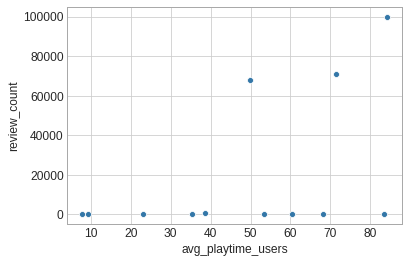

In [109]:
# Relationship between review count and hours played?
sns.scatterplot(x=merged_games['avg_playtime_users'], 
                y=merged_games['review_count'],
                color=my_blue);